# Visión por computadora con Transformers


En este cuaderno, utilizamos la biblioteca Transformers de Hugging Face para procesar imágenes. Para evitar sobrecargar el cuaderno, algunas funciones se encuentran en el archivo `utils/util.py`.


## Detección de objetos sin aprendizaje (Zero-Shot)


La detección de objetos en una imagen es una tarea clave en visión por computadora. Los modelos *zero-shot* son muy prácticos, ya que pueden detectar cualquier objeto sin necesidad de ajuste fino (*fine-tuning*). Solo es necesario proporcionarles una imagen y un *prompt* textual con las clases que se desean detectar.


### Implementación


Hemos optado por el modelo OWL-ViT de Google (`google/owlvit-base-patch32`) porque es compacto y funciona en la mayoría de las máquinas. Utilicemos el *pipeline* de Hugging Face:


In [1]:
from transformers import pipeline
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

zeroshot = pipeline("zero-shot-object-detection", model="google/owlvit-base-patch32")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Echemos un vistazo a nuestra imagen.


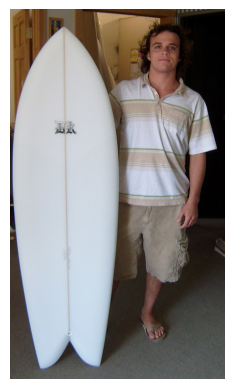

In [119]:
image=Image.open("images/coco.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

Utilicemos el modelo para dibujar los cuadros delimitadores de las detecciones predichas.


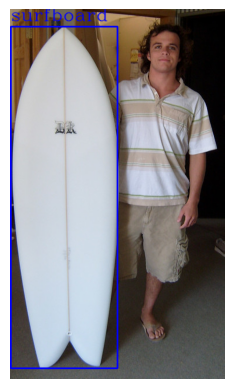

In [120]:
from utils.util import draw_box

text_prompt = "surfboard" # Vous pouvez changer la classe pour détecter autre chose "person" ou "surfboard"
output = zeroshot(image,candidate_labels = [text_prompt])
cv_image=draw_box(image,output)

plt.imshow(cv_image)
plt.axis('off') 
plt.show()

Ahora sabes cómo implementar un detector de objetos *zero-shot* en pocas líneas de código.


## Generación de leyendas para imágenes


La generación de leyendas para imágenes (*image captioning*) consiste en crear una descripción para una imagen. El modelo toma una imagen como entrada y genera una leyenda descriptiva.


### Implementación


Al igual que antes, utilizamos el *pipeline* de Hugging Face. En este caso, empleamos el modelo BLIP de Salesforce (`Salesforce/blip-image-captioning-base`).


In [121]:
captionner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")

Utilizamos la misma imagen para generar una descripción.


In [122]:
result=captionner(image)
print(result[0]['generated_text'])

a man holding a surfboard in a room


Hemos generado la descripción *"un hombre que sostiene una tabla de surf en una habitación"*, lo cual es correcto.
Ahora sabes cómo generar descripciones de imágenes. Esto es muy útil, por ejemplo, para crear *datasets* de manera automática.


## Clasificación de imágenes sin aprendizaje (Zero-Shot)


Además de la detección de objetos *zero-shot*, también podemos realizar clasificación de imágenes *zero-shot*. El principio es similar, pero en este caso se proporcionan al menos dos frases y el modelo devuelve la probabilidad de que la imagen corresponda a una u otra.


### Implementación


Utilicemos una foto de mi gato para determinar su raza:


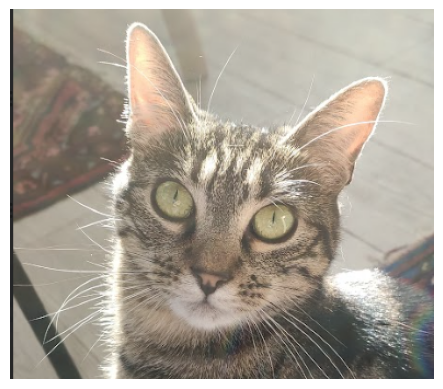

In [123]:
image=Image.open("images/tigrou.png") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

Vamos a ver si el modelo puede determinar si se trata de un *Maine Coon* o de un gato europeo.


Utilizamos el modelo CLIP de OpenAI (`openai/clip-vit-base-patch32`). Para variar, empleamos otras funciones de la biblioteca Hugging Face en lugar del *pipeline*.


In [125]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-base-patch32")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [133]:
labels = ["a photo of a european shorthair", "a photo of maine coon"]
inputs = processor(text=labels,images=image,return_tensors="pt",padding=True)
outputs = model(**inputs)

# Transformation des outputs pour obtenir des probabilités
print("Probabilité de a photo of a european shorthair : ",outputs.logits_per_image.softmax(dim=1)[0][0].item())
print("Probabilité de a photo of maine coon : ",outputs.logits_per_image.softmax(dim=1)[0][1].item())

Probabilité de a photo of a european shorthair :  0.9104425311088562
Probabilité de a photo of maine coon :  0.08955750614404678


El modelo está bastante seguro de que se trata de un gato europeo, ¡y efectivamente tiene razón!


## Segmentación de imágenes


Para este ejemplo, utilizamos el modelo SAM de Meta, que permite segmentar cualquier objeto.


### Implementación


In [2]:
sam = pipeline("mask-generation","Zigeng/SlimSAM-uniform-77")

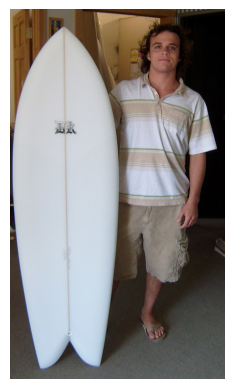

In [3]:
image=Image.open("images/coco.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

In [8]:
# ATTENTION : le traitement peut prendre plusieurs minutes
output=sam(image, points_per_batch=32)

In [5]:
masks=output["masks"]

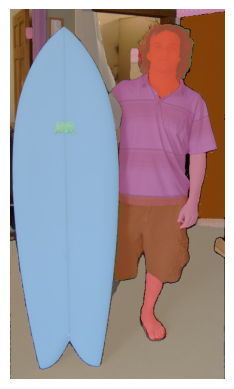

In [7]:
from utils.util import draw_masks
image_np=draw_masks(image,masks)

plt.imshow(image_np)
plt.axis('off') 
plt.show()

Como pueden ver, hemos segmentado todos los objetos de la imagen. Sin embargo, el tiempo de procesamiento fue bastante largo...
Para lograr un tiempo de inferencia más razonable, utilizamos un *prompt* con las coordenadas de un punto de la imagen. Esto permite especificar el procesamiento y obtener un resultado más rápidamente.
No es posible utilizar el *pipeline* para esta tarea.


In [9]:
from transformers import SamModel, SamProcessor

In [10]:
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")

Creemos nuestro *prompt* de coordenadas y visualicemos el punto:


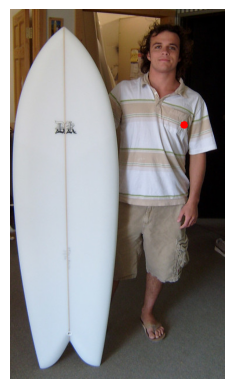

In [41]:
input_points = [[[300, 200]]]
image_np= np.array(image)
cv2.circle(image_np,input_points[0][0],radius=3,color=(255,0,0),thickness=5)
plt.imshow(image_np)
plt.axis('off')
plt.show()

In [44]:
inputs = processor(image,input_points=input_points,return_tensors="pt")
outputs = model(**inputs)
predicted_masks = processor.image_processor.post_process_masks(
  outputs.pred_masks,
  inputs["original_sizes"],
  inputs["reshaped_input_sizes"]
)

¡El procesamiento es mucho más rápido!
SAM produce **3 máscaras** por defecto. Cada máscara representa una posibilidad de segmentación de la imagen. Puedes cambiar el valor de `mask_number` para visualizar las diferentes máscaras.


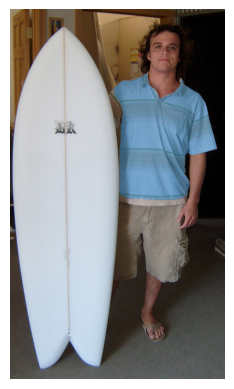

In [46]:
mask_number=2 # 0,1 or 2
mask=predicted_masks[0][:, mask_number] 
image_np=draw_masks(image,mask)
plt.imshow(image_np)
plt.axis('off') 
plt.show()

En este ejemplo, vemos que las **3 máscaras** son relevantes: la primera segmenta a la persona completa, la segunda los vestuarios y la tercera solo la camiseta.
Puedes probar cambiar las coordenadas del punto y visualizar las máscaras generadas.


## Estimación de profundidad


La estimación de profundidad es una tarea clave en visión por computadora. Es muy útil para aplicaciones como los coches autónomos, donde se estima la distancia con respecto al vehículo que tenemos delante. En la industria, también resulta interesante para organizar objetos en un paquete según el espacio restante.
Para este ejemplo, utilizamos el modelo DPT (`Intel/dpt-hybrid-midas`), que toma una imagen como entrada y devuelve un mapa de profundidad.


### Implementación


In [47]:
depth_estimator = pipeline(task="depth-estimation",model="Intel/dpt-hybrid-midas")

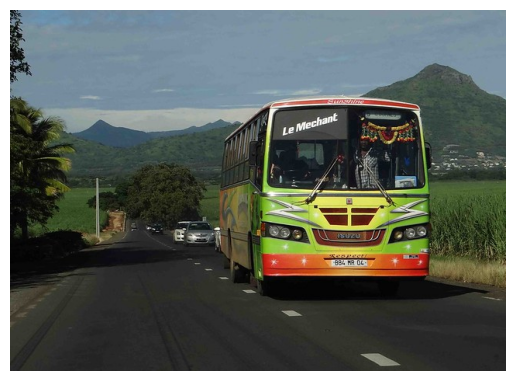

In [48]:
image=Image.open("images/coco2.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

In [57]:
outputs = depth_estimator(image)
outputs["predicted_depth"].shape

torch.Size([1, 384, 384])

Utilizamos PyTorch para ajustar la dimensión del mapa de profundidad predicho a la de nuestra imagen original y, luego, generamos una imagen del mapa de profundidad.


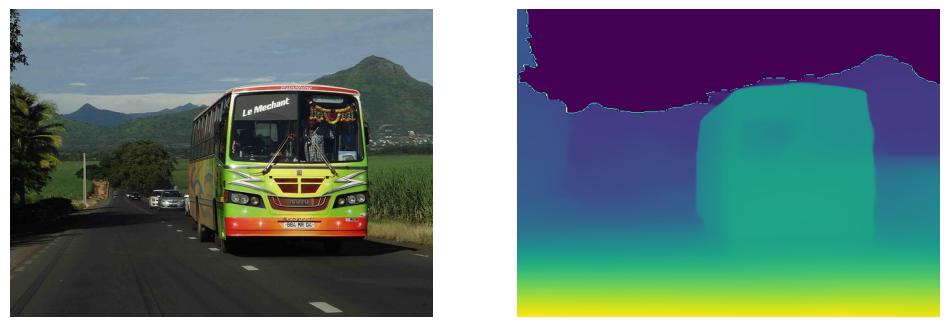

In [60]:
import torch 
prediction = torch.nn.functional.interpolate(outputs["predicted_depth"].unsqueeze(1),size=image.size[::-1],
                                             mode="bicubic",align_corners=False)
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 
ax1.imshow(image)
ax1.axis('off')  
ax2.imshow(depth)
ax2.axis('off')  
plt.show()

En el mapa de profundidad, los colores más vivos representan los objetos más cercanos. Se puede observar claramente que la carretera cercana aparece en colores muy vivos, mientras que el autobús lo hace en colores menos intensos. Por lo tanto, el mapa de profundidad es preciso.
